In [1]:
import gc
import os
import gdown
import random
import zipfile
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-11-23 22:15:07.605709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def download_from_drive(url, name):
  gdown.download(url, name, quiet=False)
  return name

def unzip(zip_path, dest_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

In [3]:
name = download_from_drive(
    url='https://drive.google.com/uc?id=1VWv4t5Mc1Iixt7vxvg6qg6wr7wqsIY3O',
    name='goproblur.zip'
)

Downloading...
From (original): https://drive.google.com/uc?id=1VWv4t5Mc1Iixt7vxvg6qg6wr7wqsIY3O
From (redirected): https://drive.google.com/uc?id=1VWv4t5Mc1Iixt7vxvg6qg6wr7wqsIY3O&confirm=t&uuid=4555bb94-1f6d-45b4-a2b0-8058b56bd5ed
To: /teamspace/studios/this_studio/goproblur.zip
100%|██████████| 788M/788M [00:05<00:00, 156MB/s]  


In [4]:
unzip(zip_path=name, dest_path='./')

In [5]:
X_train, y_train, X_test, y_test = np.load('/teamspace/studios/this_studio/GOPRO_DATA/X_train.npy'), np.load('/teamspace/studios/this_studio/GOPRO_DATA/y_train.npy'), np.load('/teamspace/studios/this_studio/GOPRO_DATA/X_test.npy'), np.load('/teamspace/studios/this_studio/GOPRO_DATA/y_test.npy')

In [6]:
print('X train:', X_train.shape,'\ny train:', y_train.shape,'\nX test:', X_test.shape,'\ny test:', y_test.shape)

X train: (2814, 224, 224, 3) 
y train: (2814, 224, 224, 3) 
X test: (400, 224, 224, 3) 
y test: (400, 224, 224, 3)


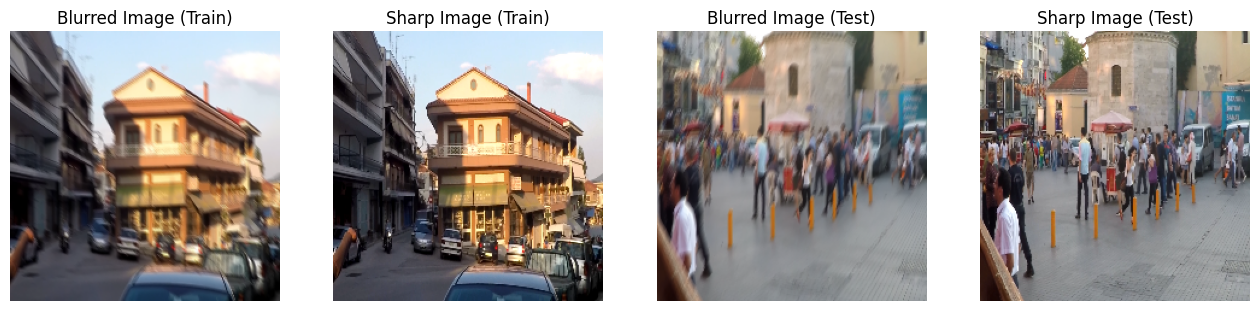

In [7]:
plt.figure(figsize=(16, 10))
plt.subplot(141), plt.imshow(X_train[0]), plt.title('Blurred Image (Train)'), plt.axis('off')
plt.subplot(142), plt.imshow(y_train[0]), plt.title('Sharp Image (Train)'), plt.axis('off')
plt.subplot(143), plt.imshow(X_test[0]), plt.title('Blurred Image (Test)'), plt.axis('off')
plt.subplot(144), plt.imshow(y_test[0]), plt.title('Sharp Image (Test)'), plt.axis('off')
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import math
from skimage.metrics import structural_similarity as compare_ssim

############################################################
#   1. CONVERSIÓN DE ARRAYS (N,H,W,C) uint8 → (N,C,H,W) float
############################################################

def convert_numpy_arrays(X):
    """
    Convierte de (N,H,W,C) uint8 [0,255] a (N,C,H,W) float32 [0,1]
    """
    if X.max() > 1.5:
        X = X.astype(np.float32) / 255.0
    else:
        X = X.astype(np.float32)

    # (N,H,W,C) → (N,C,H,W)
    return np.transpose(X, (0, 3, 1, 2)).copy()

X_train_t = convert_numpy_arrays(X_train)
y_train_t = convert_numpy_arrays(y_train)

X_test_t = convert_numpy_arrays(X_test)
y_test_t = convert_numpy_arrays(y_test)


############################################################
#   2. DATASET en memoria (sin crops)
############################################################

class ArrayDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()   # [C,H,W]
        y = torch.from_numpy(self.Y[idx]).float()
        return x, y


train_dataset = ArrayDataset(X_train_t, y_train_t)
test_dataset  = ArrayDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)


############################################################
#   3. UTILIDADES: PSNR + Charbonnier loss
############################################################

def psnr_torch(pred, target, data_range=1.0):
    mse = F.mse_loss(pred, target).item()
    if mse == 0:
        return 100.0
    return 10 * math.log10((data_range**2) / mse)

class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        super().__init__()
        self.eps = eps
    def forward(self, x, y):
        diff = x - y
        return torch.mean(torch.sqrt(diff * diff + self.eps * self.eps))


############################################################
#   4. BLOQUES DEL MODELO UFORMER
############################################################

def window_partition(x, ws):
    B, C, H, W = x.shape
    x = x.view(B, C, H//ws, ws, W//ws, ws)
    x = x.permute(0,2,4,3,5,1).contiguous()
    return x.view(-1, ws*ws, C)

def window_reverse(windows, ws, H, W):
    total = windows.shape[0]
    B = total // ((H//ws) * (W//ws))
    x = windows.view(B, H//ws, W//ws, ws, ws, -1)
    x = x.permute(0,5,1,3,2,4).contiguous()
    return x.view(B, -1, H, W)

class WindowAttention(nn.Module):
    def __init__(self, dim, ws, heads):
        super().__init__()
        self.ws = ws
        self.heads = heads
        self.dim = dim
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim*3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.heads, self.head_dim)
        q, k, v = qkv.permute(2,0,3,1,4)
        q = q * self.scale
        attn = (q @ k.transpose(-2,-1))
        attn = F.softmax(attn, dim=-1)
        out = (attn @ v).transpose(1,2).reshape(B_, N, C)
        return self.proj(out)

class LeFF(nn.Module):
    def __init__(self, dim, hidden):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden)
        self.dw = nn.Conv2d(hidden, hidden, 3, padding=1, groups=hidden)
        self.fc2 = nn.Linear(hidden, dim)
        self.act = nn.GELU()

    def forward(self, x, H, W):
        B,N,C = x.shape
        h = self.act(self.fc1(x))
        h2 = h.permute(0,2,1).view(B,-1,H,W)
        h2 = self.dw(h2)
        h2 = h2.view(B,-1,N).permute(0,2,1)
        return self.fc2(self.act(h2))


class LeWinBlock(nn.Module):
    def __init__(self, dim, ws=8, heads=4, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = WindowAttention(dim, ws, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = LeFF(dim, int(dim*mlp_ratio))
        self.ws = ws

    def forward(self, x, H, W):
        B,N,C = x.shape
        x1 = self.norm1(x)
        x1 = x1.view(B,H,W,C).permute(0,3,1,2)
        win = window_partition(x1, self.ws)
        win = self.attn(win)
        x2 = window_reverse(win, self.ws, H, W)
        x2 = x2.permute(0,2,3,1).view(B,N,C)
        x = x + x2
        x = x + self.mlp(self.norm2(x), H, W)
        return x


############################################################
#   5. UFORMER PEQUEÑO (CORREGIDO)
############################################################

class UformerDeblur(nn.Module):
    def __init__(self, base=32, ws=8, heads=4):
        super().__init__()
        self.ws = ws
        self.in_proj = nn.Conv2d(3, base, 3, padding=1)

        self.enc1 = nn.ModuleList([LeWinBlock(base, ws, heads) for _ in range(2)])
        self.down1 = nn.Conv2d(base, base*2, 4, stride=2, padding=1)

        self.enc2 = nn.ModuleList([LeWinBlock(base*2, ws, heads) for _ in range(2)])
        self.down2 = nn.Conv2d(base*2, base*4, 4, stride=2, padding=1)

        self.bot = nn.ModuleList([LeWinBlock(base*4, ws, heads) for _ in range(2)])

        self.up1 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        # AGREGADO: reducción de canales después del concat en decoder 1
        self.reduce1 = nn.Conv2d(base*4, base*2, 1)
        self.dec1 = nn.ModuleList([LeWinBlock(base*2, ws, heads) for _ in range(2)])

        self.up2 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        # AGREGADO: reducción de canales después del concat en decoder 2
        self.reduce2 = nn.Conv2d(base*2, base, 1)
        self.dec2 = nn.ModuleList([LeWinBlock(base, ws, heads) for _ in range(2)])

        self.out_proj = nn.Conv2d(base, 3, 3, padding=1)

        # Modulator scale+bias - CORREGIDO para que coincidan con los canales reducidos
        self.mod1_scale = nn.Parameter(torch.zeros(1, base*2, ws, ws))
        self.mod1_bias  = nn.Parameter(torch.zeros(1, base*2, ws, ws))

        self.mod2_scale = nn.Parameter(torch.zeros(1, base, ws, ws))
        self.mod2_bias  = nn.Parameter(torch.zeros(1, base, ws, ws))

    def apply_modulator(self, x, scale, bias):
        B,C,H,W = x.shape
        reps_h = H // self.ws
        reps_w = W // self.ws
        s = scale.repeat(1,1,reps_h,reps_w)
        b = bias.repeat(1,1,reps_h,reps_w)
        return x * (1 + s) + b

    def run_blocks(self, x, blocks):
        B,C,H,W = x.shape
        N = H*W
        x = x.permute(0,2,3,1).reshape(B,N,C)
        for blk in blocks:
            x = blk(x, H, W)
        return x.view(B,H,W,C).permute(0,3,1,2)

    def forward(self, x):
        # pad si hiciera falta (aquí no porque 224%8=0)
        f = self.in_proj(x)

        # encoder 1
        e1 = self.run_blocks(f, self.enc1)
        d1 = self.down1(e1)

        # encoder 2
        e2 = self.run_blocks(d1, self.enc2)
        d2 = self.down2(e2)

        # bottleneck
        b = self.run_blocks(d2, self.bot)

        # decoder 1
        u1 = self.up1(b)
        u1 = torch.cat([u1, e2], dim=1)  # base*4 canales
        u1 = self.reduce1(u1)             # REDUCIR a base*2
        u1 = self.apply_modulator(u1, self.mod1_scale, self.mod1_bias)
        u1 = self.run_blocks(u1, self.dec1)

        # decoder 2
        u2 = self.up2(u1)
        u2 = torch.cat([u2, e1], dim=1)  # base*2 canales
        u2 = self.reduce2(u2)             # REDUCIR a base
        u2 = self.apply_modulator(u2, self.mod2_scale, self.mod2_bias)
        u2 = self.run_blocks(u2, self.dec2)

        out = self.out_proj(u2)
        return x + out    # residual


############################################################
#   6. ENTRENAMIENTO
############################################################

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = UformerDeblur(base=32, ws=8, heads=4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
loss_fn = CharbonnierLoss()

EPOCHS = 100
best_psnr = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}"):
        xb = xb.to(device)
        yb = yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()

    # evaluar
    model.eval()
    psnr_total = 0
    ssim_total = 0
    count = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)
            pred = torch.clamp(pred, 0, 1)

            p = pred[0].cpu().numpy().transpose(1,2,0)
            t = yb[0].cpu().numpy().transpose(1,2,0)

            psnr_total += psnr_torch(pred, yb)
            ssim_total += compare_ssim(t, p, channel_axis=2, data_range=1.0)
            count += 1

    psnr_mean = psnr_total / count
    ssim_mean = ssim_total / count

    print(f"[Epoch {epoch}] Loss={epoch_loss/len(train_loader):.4f}   PSNR={psnr_mean:.3f}   SSIM={ssim_mean:.4f}")

    # guardar best
    if psnr_mean > best_psnr:
        best_psnr = psnr_mean
        torch.save(model.state_dict(), "best_uformer.pth")
        print("✔ Guardado modelo mejorado (best_uformer.pth)")

Device: cuda


Epoch 1: 100%|██████████| 352/352 [10:13<00:00,  1.74s/it]


[Epoch 1] Loss=0.0377   PSNR=28.359   SSIM=0.9200
✔ Guardado modelo mejorado (best_uformer.pth)


Epoch 2: 100%|██████████| 352/352 [10:09<00:00,  1.73s/it]


[Epoch 2] Loss=0.0328   PSNR=28.605   SSIM=0.9230
✔ Guardado modelo mejorado (best_uformer.pth)


Epoch 3:   4%|▍         | 15/352 [00:27<10:27,  1.86s/it]


KeyboardInterrupt: 

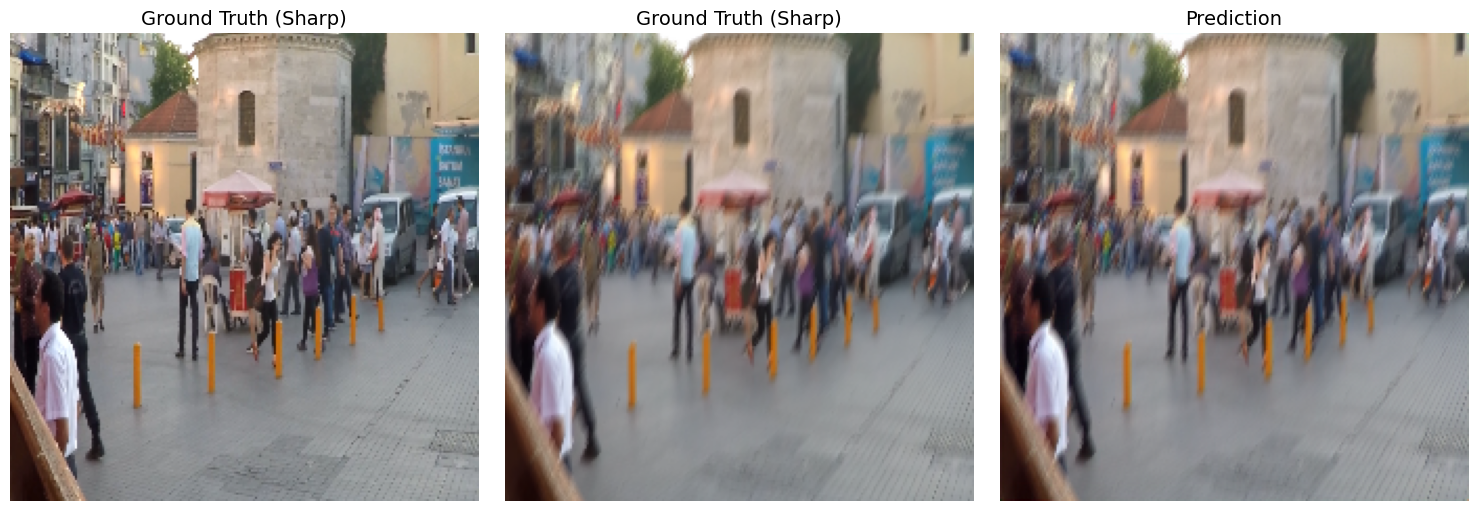

✓ Imagen guardada como 'prediction_comparison.png'


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

############################################################
#   PARTE 1: CARGAR MODELO Y HACER PREDICCIÓN
############################################################

# Cargar el modelo guardado
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UformerDeblur(base=32, ws=8, heads=4).to(device)
model.load_state_dict(torch.load("best_uformer.pth", map_location=device))
model.eval()

# Hacer predicción en el primer ejemplo de test
with torch.no_grad():
    x_sample = torch.from_numpy(X_test_t[0:1]).float().to(device)  # [1, 3, 224, 224]
    y_sample = torch.from_numpy(y_test_t[0:1]).float().to(device)
    
    pred_sample = model(x_sample)
    pred_sample = torch.clamp(pred_sample, 0, 1)

# Convertir a numpy para visualizar (C,H,W) -> (H,W,C)
x_show = x_sample[0].cpu().numpy().transpose(1, 2, 0)
y_show = y_sample[0].cpu().numpy().transpose(1, 2, 0)
pred_show = pred_sample[0].cpu().numpy().transpose(1, 2, 0)

# Plotear
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(y_show)
axes[0].set_title('Ground Truth (Sharp)', fontsize=14)
axes[0].axis('off')

axes[1].imshow(x_show)
axes[1].set_title('Ground Truth (Sharp)', fontsize=14)
axes[1].axis('off')

axes[2].imshow(pred_show)
axes[2].set_title('Prediction', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Imagen guardada como 'prediction_comparison.png'")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import math
from skimage.metrics import structural_similarity as compare_ssim

############################################################
#   1. CONVERSIÓN DE ARRAYS
############################################################

def convert_numpy_arrays(X):
    """Convierte de (N,H,W,C) uint8 [0,255] a (N,C,H,W) float32 [0,1]"""
    if X.max() > 1.5:
        X = X.astype(np.float32) / 255.0
    else:
        X = X.astype(np.float32)
    return np.transpose(X, (0, 3, 1, 2)).copy()

X_train_t = convert_numpy_arrays(X_train)
y_train_t = convert_numpy_arrays(y_train)
X_test_t = convert_numpy_arrays(X_test)
y_test_t = convert_numpy_arrays(y_test)

############################################################
#   2. DATASET
############################################################

class ArrayDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(self.Y[idx]).float()
        return x, y

train_dataset = ArrayDataset(X_train_t, y_train_t)
test_dataset = ArrayDataset(X_test_t, y_test_t)

# Batch size más grande para modelo ligero
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

############################################################
#   3. CHARBONNIER LOSS
############################################################

class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        super().__init__()
        self.eps = eps
    def forward(self, x, y):
        diff = x - y
        return torch.mean(torch.sqrt(diff * diff + self.eps * self.eps))

############################################################
#   4. BLOQUES TRANSFORMER
############################################################

def window_partition(x, ws):
    B, C, H, W = x.shape
    x = x.view(B, C, H//ws, ws, W//ws, ws)
    x = x.permute(0,2,4,3,5,1).contiguous()
    return x.view(-1, ws*ws, C)

def window_reverse(windows, ws, H, W):
    total = windows.shape[0]
    B = total // ((H//ws) * (W//ws))
    x = windows.view(B, H//ws, W//ws, ws, ws, -1)
    x = x.permute(0,5,1,3,2,4).contiguous()
    return x.view(B, -1, H, W)

class WindowAttention(nn.Module):
    def __init__(self, dim, ws, heads):
        super().__init__()
        self.ws = ws
        self.heads = heads
        self.dim = dim
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim*3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.heads, self.head_dim)
        q, k, v = qkv.permute(2,0,3,1,4)
        q = q * self.scale
        attn = (q @ k.transpose(-2,-1))
        attn = F.softmax(attn, dim=-1)
        out = (attn @ v).transpose(1,2).reshape(B_, N, C)
        return self.proj(out)

class LeFF(nn.Module):
    def __init__(self, dim, hidden):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden)
        self.dw = nn.Conv2d(hidden, hidden, 3, padding=1, groups=hidden)
        self.fc2 = nn.Linear(hidden, dim)
        self.act = nn.GELU()

    def forward(self, x, H, W):
        B,N,C = x.shape
        h = self.act(self.fc1(x))
        h2 = h.permute(0,2,1).view(B,-1,H,W)
        h2 = self.dw(h2)
        h2 = h2.view(B,-1,N).permute(0,2,1)
        return self.fc2(self.act(h2))

class LeWinBlock(nn.Module):
    def __init__(self, dim, ws=8, heads=4, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, ws, heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = LeFF(dim, int(dim*mlp_ratio))
        self.ws = ws

    def forward(self, x, H, W):
        B,N,C = x.shape
        x1 = self.norm1(x)
        x1 = x1.view(B,H,W,C).permute(0,3,1,2)
        win = window_partition(x1, self.ws)
        win = self.attn(win)
        x2 = window_reverse(win, self.ws, H, W)
        x2 = x2.permute(0,2,3,1).view(B,N,C)
        x = x + x2
        x = x + self.mlp(self.norm2(x), H, W)
        return x

############################################################
#   5. LIGHTDEBLURNET
############################################################

class LightDeblurNet(nn.Module):
    """Modelo aligerado optimizado para 224x224x3"""
    def __init__(self, base=24, ws=8, heads=2):
        super().__init__()
        self.ws = ws
        
        self.in_proj = nn.Conv2d(3, base, 3, padding=1)
        
        # Encoder (1 bloque por nivel)
        self.enc1 = LeWinBlock(base, ws, heads, mlp_ratio=2)
        self.down1 = nn.Conv2d(base, base*2, 4, stride=2, padding=1)
        
        self.enc2 = LeWinBlock(base*2, ws, heads, mlp_ratio=2)
        self.down2 = nn.Conv2d(base*2, base*4, 4, stride=2, padding=1)
        
        # Bottleneck
        self.bot = LeWinBlock(base*4, ws, heads, mlp_ratio=2)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.reduce1 = nn.Conv2d(base*4, base*2, 1)
        self.dec1 = LeWinBlock(base*2, ws, heads, mlp_ratio=2)
        
        self.up2 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.reduce2 = nn.Conv2d(base*2, base, 1)
        self.dec2 = LeWinBlock(base, ws, heads, mlp_ratio=2)
        
        self.out_proj = nn.Conv2d(base, 3, 3, padding=1)
    
    def run_block(self, x, block):
        B, C, H, W = x.shape
        N = H * W
        x_flat = x.permute(0, 2, 3, 1).reshape(B, N, C)
        x_out = block(x_flat, H, W)
        return x_out.view(B, H, W, C).permute(0, 3, 1, 2)
    
    def forward(self, x):
        f = self.in_proj(x)
        e1 = self.run_block(f, self.enc1)
        d1 = self.down1(e1)
        
        e2 = self.run_block(d1, self.enc2)
        d2 = self.down2(e2)
        
        b = self.run_block(d2, self.bot)
        
        u1 = self.up1(b)
        u1 = torch.cat([u1, e2], dim=1)
        u1 = self.reduce1(u1)
        u1 = self.run_block(u1, self.dec1)
        
        u2 = self.up2(u1)
        u2 = torch.cat([u2, e1], dim=1)
        u2 = self.reduce2(u2)
        u2 = self.run_block(u2, self.dec2)
        
        out = self.out_proj(u2)
        return x + out

############################################################
#   6. ENTRENAMIENTO
############################################################

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Device:", device)
# print("="*60)
# print("ENTRENANDO: LightDeblurNet")
# print("Parámetros: base=24, ws=8, heads=2")
# print("="*60)

# model = LightDeblurNet(base=24, ws=8, heads=2).to(device)

# # Contar parámetros
# params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Parámetros entrenables: {params:,}")

# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
# loss_fn = CharbonnierLoss()

# # Mixed precision para más velocidad
# scaler = torch.cuda.amp.GradScaler()

# EPOCHS = 50
# best_psnr = 0

# for epoch in range(1, EPOCHS+1):
#     model.train()
#     epoch_loss = 0

#     for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}"):
#         xb = xb.to(device)
#         yb = yb.to(device)

#         # Mixed precision
#         with torch.cuda.amp.autocast():
#             pred = model(xb)
#             loss = loss_fn(pred, yb)

#         optimizer.zero_grad()
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         epoch_loss += loss.item()

#     scheduler.step()

#     # Evaluación
#     model.eval()
#     psnr_list = []
#     ssim_list = []

#     with torch.no_grad():
#         for xb, yb in test_loader:
#             xb = xb.to(device)
#             yb = yb.to(device)

#             pred = model(xb)
#             pred = torch.clamp(pred, 0, 1)

#             # Calcular métricas por cada imagen
#             for i in range(pred.shape[0]):
#                 # PSNR
#                 mse = F.mse_loss(pred[i], yb[i]).item()
#                 if mse < 1e-10:
#                     psnr_val = 100.0
#                 else:
#                     psnr_val = 10 * math.log10(1.0 / mse)
#                 psnr_list.append(psnr_val)
                
#                 # SSIM
#                 p = pred[i].cpu().numpy().transpose(1,2,0)
#                 t = yb[i].cpu().numpy().transpose(1,2,0)
#                 ssim_val = compare_ssim(t, p, channel_axis=2, data_range=1.0)
#                 ssim_list.append(ssim_val)

#     psnr_mean = np.mean(psnr_list)
#     ssim_mean = np.mean(ssim_list)
#     psnr_std = np.std(psnr_list)
#     ssim_std = np.std(ssim_list)

#     print(f"[Epoch {epoch}] Loss={epoch_loss/len(train_loader):.4f}   "
#           f"PSNR={psnr_mean:.3f}±{psnr_std:.3f}   "
#           f"SSIM={ssim_mean:.4f}±{ssim_std:.4f}")

#     # Guardar best
#     if psnr_mean > best_psnr:
#         best_psnr = psnr_mean
#         torch.save(model.state_dict(), "best_lightdeblur.pth")
#         print("✔ Guardado modelo mejorado (best_lightdeblur.pth)")

# print("\n" + "="*60)
# print(f"ENTRENAMIENTO COMPLETADO")
# print(f"Mejor PSNR: {best_psnr:.3f}")
# print("="*60)

Device: cuda
ENTRENAMIENTO MEJORADO - LightDeblurNet
Parámetros: 249,819



Using cache found in /home/zeus/.cache/torch/hub/pytorch_vision_v0.10.0


✓ Usando Combined Loss (L1 + Perceptual)


/tmp/ipykernel_4735/2613152270.py:226: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Iniciando entrenamiento...



Epoch 1/80:   0%|          | 0/235 [00:00<?, ?it/s]/tmp/ipykernel_4735/2613152270.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/80: 100%|██████████| 235/235 [00:58<00:00,  4.02it/s, loss=0.5514]



[Epoch 1] Loss=0.6196   PSNR=27.96±2.43   SSIM=0.9150   LR=0.000500
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 2/80: 100%|██████████| 235/235 [00:51<00:00,  4.56it/s, loss=0.4365]



[Epoch 2] Loss=0.5841   PSNR=28.11±2.45   SSIM=0.9173   LR=0.000488
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 3/80: 100%|██████████| 235/235 [00:51<00:00,  4.54it/s, loss=0.5616]



[Epoch 3] Loss=0.5781   PSNR=28.05±2.40   SSIM=0.9164   LR=0.000452


Epoch 4/80: 100%|██████████| 235/235 [00:51<00:00,  4.52it/s, loss=0.5962]



[Epoch 4] Loss=0.5618   PSNR=28.14±2.37   SSIM=0.9177   LR=0.000397
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 5/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5435]



[Epoch 5] Loss=0.5406   PSNR=28.13±2.32   SSIM=0.9183   LR=0.000328


Epoch 6/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.4231]



[Epoch 6] Loss=0.5294   PSNR=28.23±2.38   SSIM=0.9194   LR=0.000251
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 7/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.6066]



[Epoch 7] Loss=0.5231   PSNR=28.28±2.39   SSIM=0.9205   LR=0.000173
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 8/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5485]



[Epoch 8] Loss=0.5190   PSNR=28.28±2.39   SSIM=0.9206   LR=0.000104


Epoch 9/80: 100%|██████████| 235/235 [00:52<00:00,  4.47it/s, loss=0.4483]



[Epoch 9] Loss=0.5160   PSNR=28.30±2.41   SSIM=0.9203   LR=0.000049
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 10/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5326]



[Epoch 10] Loss=0.5150   PSNR=28.30±2.41   SSIM=0.9206   LR=0.000013
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 11/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4007]



[Epoch 11] Loss=0.5205   PSNR=28.30±2.41   SSIM=0.9207   LR=0.000500


Epoch 12/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.6560]



[Epoch 12] Loss=0.5134   PSNR=28.37±2.46   SSIM=0.9207   LR=0.000497
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 13/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.6312]



[Epoch 13] Loss=0.5078   PSNR=28.28±2.37   SSIM=0.9214   LR=0.000488


Epoch 14/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.2938]



[Epoch 14] Loss=0.5027   PSNR=28.28±2.42   SSIM=0.9197   LR=0.000473


Epoch 15/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3728]



[Epoch 15] Loss=0.4985   PSNR=28.46±2.52   SSIM=0.9221   LR=0.000452
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 16/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5780]



[Epoch 16] Loss=0.4954   PSNR=28.50±2.55   SSIM=0.9218   LR=0.000427
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 17/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4816]



[Epoch 17] Loss=0.4918   PSNR=28.58±2.63   SSIM=0.9229   LR=0.000397
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 18/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4027]



[Epoch 18] Loss=0.4890   PSNR=28.59±2.66   SSIM=0.9231   LR=0.000364
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 19/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5409]



[Epoch 19] Loss=0.4867   PSNR=28.62±2.65   SSIM=0.9228   LR=0.000328
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 20/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.6909]



[Epoch 20] Loss=0.4843   PSNR=28.60±2.66   SSIM=0.9220   LR=0.000290


Epoch 21/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3313]



[Epoch 21] Loss=0.4816   PSNR=28.69±2.70   SSIM=0.9237   LR=0.000251
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 22/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4870]



[Epoch 22] Loss=0.4791   PSNR=28.67±2.69   SSIM=0.9240   LR=0.000211


Epoch 23/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4238]



[Epoch 23] Loss=0.4771   PSNR=28.71±2.73   SSIM=0.9240   LR=0.000173
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 24/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5156]



[Epoch 24] Loss=0.4753   PSNR=28.76±2.76   SSIM=0.9243   LR=0.000137
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 25/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4352]



[Epoch 25] Loss=0.4741   PSNR=28.68±2.69   SSIM=0.9239   LR=0.000104


Epoch 26/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.6836]



[Epoch 26] Loss=0.4727   PSNR=28.74±2.73   SSIM=0.9244   LR=0.000074


Epoch 27/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3735]



[Epoch 27] Loss=0.4714   PSNR=28.72±2.72   SSIM=0.9244   LR=0.000049


Epoch 28/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3878]



[Epoch 28] Loss=0.4707   PSNR=28.76±2.75   SSIM=0.9246   LR=0.000028
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 29/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4275]



[Epoch 29] Loss=0.4704   PSNR=28.72±2.73   SSIM=0.9241   LR=0.000013


Epoch 30/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.6099]



[Epoch 30] Loss=0.4705   PSNR=28.76±2.75   SSIM=0.9246   LR=0.000004


Epoch 31/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4162]



[Epoch 31] Loss=0.4795   PSNR=28.70±2.73   SSIM=0.9238   LR=0.000500


Epoch 32/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5970]



[Epoch 32] Loss=0.4759   PSNR=28.73±2.74   SSIM=0.9240   LR=0.000499

📉 Learning rate reducido: 0.000497 → 0.000248


Epoch 33/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5023]



[Epoch 33] Loss=0.4695   PSNR=28.79±2.76   SSIM=0.9253   LR=0.000248
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 34/80: 100%|██████████| 235/235 [00:52<00:00,  4.47it/s, loss=0.5732]



[Epoch 34] Loss=0.4730   PSNR=28.79±2.77   SSIM=0.9251   LR=0.000493
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 35/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4813]



[Epoch 35] Loss=0.4687   PSNR=28.74±2.71   SSIM=0.9248   LR=0.000488


Epoch 36/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3808]



[Epoch 36] Loss=0.4668   PSNR=28.85±2.74   SSIM=0.9263   LR=0.000481
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 37/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4715]



[Epoch 37] Loss=0.4644   PSNR=28.86±2.80   SSIM=0.9258   LR=0.000473
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 38/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4210]



[Epoch 38] Loss=0.4624   PSNR=28.84±2.80   SSIM=0.9257   LR=0.000463


Epoch 39/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3769]



[Epoch 39] Loss=0.4599   PSNR=28.92±2.85   SSIM=0.9263   LR=0.000452
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 40/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4154]



[Epoch 40] Loss=0.4582   PSNR=28.91±2.84   SSIM=0.9269   LR=0.000440


Epoch 41/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4696]



[Epoch 41] Loss=0.4565   PSNR=28.89±2.80   SSIM=0.9265   LR=0.000427


Epoch 42/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4444]



[Epoch 42] Loss=0.4541   PSNR=28.89±2.86   SSIM=0.9262   LR=0.000413


Epoch 43/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5883]



[Epoch 43] Loss=0.4522   PSNR=28.88±2.78   SSIM=0.9263   LR=0.000397

📉 Learning rate reducido: 0.000381 → 0.000190


Epoch 44/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.6716]



[Epoch 44] Loss=0.4480   PSNR=28.98±2.89   SSIM=0.9272   LR=0.000190
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 45/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3772]



[Epoch 45] Loss=0.4498   PSNR=28.87±2.84   SSIM=0.9261   LR=0.000364


Epoch 46/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3510]



[Epoch 46] Loss=0.4481   PSNR=28.96±2.87   SSIM=0.9267   LR=0.000346


Epoch 47/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4298]



[Epoch 47] Loss=0.4467   PSNR=28.90±2.84   SSIM=0.9269   LR=0.000328


Epoch 48/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4888]



[Epoch 48] Loss=0.4457   PSNR=28.83±2.81   SSIM=0.9259   LR=0.000309

📉 Learning rate reducido: 0.000290 → 0.000145


Epoch 49/80: 100%|██████████| 235/235 [00:52<00:00,  4.47it/s, loss=0.3764]



[Epoch 49] Loss=0.4416   PSNR=29.00±2.90   SSIM=0.9277   LR=0.000145
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 50/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3287]



[Epoch 50] Loss=0.4423   PSNR=28.92±2.83   SSIM=0.9272   LR=0.000270


Epoch 51/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3435]



[Epoch 51] Loss=0.4413   PSNR=29.00±2.90   SSIM=0.9276   LR=0.000251
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 52/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4547]



[Epoch 52] Loss=0.4408   PSNR=29.03±2.91   SSIM=0.9278   LR=0.000231
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 53/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4684]



[Epoch 53] Loss=0.4392   PSNR=28.98±2.87   SSIM=0.9275   LR=0.000211


Epoch 54/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4980]



[Epoch 54] Loss=0.4388   PSNR=28.93±2.90   SSIM=0.9267   LR=0.000192


Epoch 55/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.2685]



[Epoch 55] Loss=0.4373   PSNR=29.02±2.89   SSIM=0.9280   LR=0.000173


Epoch 56/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5821]



[Epoch 56] Loss=0.4367   PSNR=29.04±2.91   SSIM=0.9281   LR=0.000155
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 57/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4222]



[Epoch 57] Loss=0.4351   PSNR=29.03±2.88   SSIM=0.9283   LR=0.000137


Epoch 58/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4686]



[Epoch 58] Loss=0.4351   PSNR=29.01±2.93   SSIM=0.9278   LR=0.000120


Epoch 59/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3247]



[Epoch 59] Loss=0.4339   PSNR=29.00±2.91   SSIM=0.9275   LR=0.000104


Epoch 60/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5846]



[Epoch 60] Loss=0.4335   PSNR=28.99±2.89   SSIM=0.9278   LR=0.000088

📉 Learning rate reducido: 0.000074 → 0.000037


Epoch 61/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.5472]



[Epoch 61] Loss=0.4322   PSNR=29.01±2.87   SSIM=0.9281   LR=0.000037


Epoch 62/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3297]



[Epoch 62] Loss=0.4318   PSNR=29.02±2.92   SSIM=0.9278   LR=0.000061


Epoch 63/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4236]



[Epoch 63] Loss=0.4317   PSNR=29.00±2.89   SSIM=0.9280   LR=0.000049


Epoch 64/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.4595]



[Epoch 64] Loss=0.4317   PSNR=29.04±2.91   SSIM=0.9282   LR=0.000038

📉 Learning rate reducido: 0.000028 → 0.000014


Epoch 65/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3944]



[Epoch 65] Loss=0.4309   PSNR=29.04±2.92   SSIM=0.9282   LR=0.000014
✔ Guardado mejor modelo (best_lightdeblur_v2.pth)


Epoch 66/80: 100%|██████████| 235/235 [00:52<00:00,  4.48it/s, loss=0.3372]



[Epoch 66] Loss=0.4306   PSNR=29.02±2.91   SSIM=0.9280   LR=0.000020

⚠ Early stopping activado en epoch 66

ENTRENAMIENTO COMPLETADO
Mejor PSNR: 29.04
✓ Historial guardado en 'training_history.npy'
✓ Curvas guardadas en 'training_curves.png'


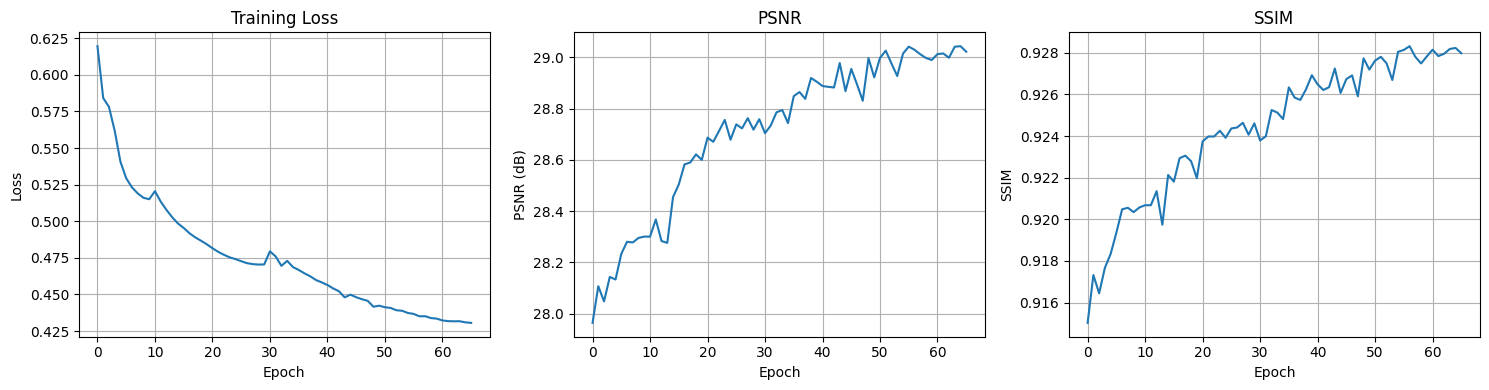

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import math
from skimage.metrics import structural_similarity as compare_ssim

############################################################
#   MEJORAS PARA ACELERAR CONVERGENCIA
############################################################

class PerceptualLoss(nn.Module):
    """
    Loss perceptual usando VGG - ayuda MUCHÍSIMO en restauración
    """
    def __init__(self):
        super().__init__()
        # Cargar VGG16 preentrenado
        vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
        # Usar las primeras capas conv
        self.features = nn.Sequential(*list(vgg.features)[:16]).eval()
        
        # Congelar parámetros
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Registrar buffers para normalización
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def forward(self, pred, target):
        # IMPORTANTE: Convertir a float32 para VGG
        pred = pred.float()
        target = target.float()
        
        # Normalizar como espera VGG
        pred_norm = (pred - self.mean) / self.std
        target_norm = (target - self.mean) / self.std
        
        pred_feat = self.features(pred_norm)
        target_feat = self.features(target_norm)
        
        return F.mse_loss(pred_feat, target_feat)


class CombinedLoss(nn.Module):
    """
    Combina múltiples losses para mejor entrenamiento
    """
    def __init__(self, use_perceptual=True, device='cuda'):
        super().__init__()
        self.l1_loss = nn.L1Loss()
        self.use_perceptual = use_perceptual
        
        if use_perceptual:
            self.perceptual = PerceptualLoss().to(device)
    
    def forward(self, pred, target):
        # L1 loss (más estable que MSE al inicio)
        l1 = self.l1_loss(pred, target)
        
        # Perceptual loss (captura estructuras)
        if self.use_perceptual:
            perc = self.perceptual(pred, target)
            return l1 + 0.1 * perc  # Peso menor para perceptual
        
        return l1


class EarlyStopping:
    """
    Early stopping para evitar sobreentrenamiento
    """
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.should_stop = False
    
    def __call__(self, val_metric):
        if self.best_score is None:
            self.best_score = val_metric
        elif val_metric < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_score = val_metric
            self.counter = 0


class ReduceLROnPlateau:
    """
    Reduce learning rate cuando se estanca
    """
    def __init__(self, optimizer, patience=3, factor=0.5, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.counter = 0
        self.best_score = None
    
    def step(self, val_metric):
        if self.best_score is None:
            self.best_score = val_metric
        elif val_metric <= self.best_score + 0.001:
            self.counter += 1
            if self.counter >= self.patience:
                self._reduce_lr()
                self.counter = 0
        else:
            self.best_score = val_metric
            self.counter = 0
    
    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f"\n📉 Learning rate reducido: {old_lr:.6f} → {new_lr:.6f}")


############################################################
#   DATA AUGMENTATION PARA MEJOR GENERALIZACIÓN
############################################################

class AugmentedDataset(Dataset):
    """Dataset con augmentation on-the-fly"""
    def __init__(self, X, Y, augment=True):
        self.X = X
        self.Y = Y
        self.augment = augment
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(self.Y[idx]).float()
        
        if self.augment and np.random.rand() > 0.5:
            # Flip horizontal
            if np.random.rand() > 0.5:
                x = torch.flip(x, [2])
                y = torch.flip(y, [2])
            
            # Flip vertical
            if np.random.rand() > 0.5:
                x = torch.flip(x, [1])
                y = torch.flip(y, [1])
            
            # Rotación 90 grados
            if np.random.rand() > 0.5:
                k = np.random.randint(1, 4)
                x = torch.rot90(x, k, [1, 2])
                y = torch.rot90(y, k, [1, 2])
        
        return x, y


############################################################
#   CONFIGURACIÓN MEJORADA
############################################################

def convert_numpy_arrays(X):
    if X.max() > 1.5:
        X = X.astype(np.float32) / 255.0
    else:
        X = X.astype(np.float32)
    return np.transpose(X, (0, 3, 1, 2)).copy()

X_train_t = convert_numpy_arrays(X_train)
y_train_t = convert_numpy_arrays(y_train)
X_test_t = convert_numpy_arrays(X_test)
y_test_t = convert_numpy_arrays(y_test)

# Dataset CON augmentation
train_dataset = AugmentedDataset(X_train_t, y_train_t, augment=True)
test_dataset = AugmentedDataset(X_test_t, y_test_t, augment=False)

# Batch size ajustado
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


############################################################
#   ENTRENAMIENTO MEJORADO
############################################################

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("="*60)
print("ENTRENAMIENTO MEJORADO - LightDeblurNet")
print("="*60)

# Cargar tu modelo (LightDeblurNet o el que uses)
model = LightDeblurNet(base=24, ws=8, heads=2).to(device)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros: {params:,}\n")

# CAMBIO 1: Loss mejorada (L1 + Perceptual)
loss_fn = CombinedLoss(use_perceptual=True, device=device)
print("✓ Usando Combined Loss (L1 + Perceptual)")

# CAMBIO 2: Learning rate inicial más alto con warmup
INITIAL_LR = 5e-4  # Mayor que antes
optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, 
                              weight_decay=0.01, betas=(0.9, 0.999))

# CAMBIO 3: Scheduler más agresivo
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# CAMBIO 4: Callbacks
early_stop = EarlyStopping(patience=10, min_delta=0.01)
lr_reducer = ReduceLROnPlateau(optimizer, patience=4, factor=0.5)

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

EPOCHS = 80
best_psnr = 0
history = {'train_loss': [], 'psnr': [], 'ssim': []}

print("Iniciando entrenamiento...\n")

for epoch in range(1, EPOCHS+1):
    # ============ TRAINING ============
    model.train()
    epoch_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb in train_bar:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # Mixed precision solo para el modelo, NO para la loss
        with torch.cuda.amp.autocast():
            pred = model(xb)
        
        # Loss fuera de autocast para evitar problemas con VGG
        loss = loss_fn(pred, yb)

        optimizer.zero_grad(set_to_none=True)  # Más eficiente que zero_grad()
        scaler.scale(loss).backward()
        
        # CAMBIO 5: Gradient clipping para estabilidad
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_loss)

    # ============ VALIDATION ============
    model.eval()
    psnr_list = []
    ssim_list = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            pred = model(xb)
            pred = torch.clamp(pred, 0, 1)

            for i in range(pred.shape[0]):
                mse = F.mse_loss(pred[i], yb[i]).item()
                psnr_val = 10 * math.log10(1.0 / (mse + 1e-10))
                psnr_list.append(psnr_val)
                
                p = pred[i].cpu().numpy().transpose(1,2,0)
                t = yb[i].cpu().numpy().transpose(1,2,0)
                ssim_val = compare_ssim(t, p, channel_axis=2, data_range=1.0)
                ssim_list.append(ssim_val)

    psnr_mean = np.mean(psnr_list)
    ssim_mean = np.mean(ssim_list)
    psnr_std = np.std(psnr_list)
    
    history['psnr'].append(psnr_mean)
    history['ssim'].append(ssim_mean)

    # Learning rate actual
    current_lr = optimizer.param_groups[0]['lr']

    print(f"\n[Epoch {epoch}] Loss={avg_loss:.4f}   "
          f"PSNR={psnr_mean:.2f}±{psnr_std:.2f}   "
          f"SSIM={ssim_mean:.4f}   LR={current_lr:.6f}")

    # ============ CALLBACKS ============
    
    # Step del scheduler
    scheduler.step()
    
    # Reduce LR on plateau
    lr_reducer.step(psnr_mean)
    
    # Early stopping
    early_stop(psnr_mean)
    
    # Guardar mejor modelo
    if psnr_mean > best_psnr:
        best_psnr = psnr_mean
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'psnr': psnr_mean,
            'ssim': ssim_mean,
        }, "best_lightdeblur_v2.pth")
        print("✔ Guardado mejor modelo (best_lightdeblur_v2.pth)")
    
    # Checkear early stopping
    if early_stop.should_stop:
        print(f"\n⚠ Early stopping activado en epoch {epoch}")
        break

print("\n" + "="*60)
print(f"ENTRENAMIENTO COMPLETADO")
print(f"Mejor PSNR: {best_psnr:.2f}")
print("="*60)

# Guardar historial
np.save('training_history.npy', history)
print("✓ Historial guardado en 'training_history.npy'")


############################################################
#   BONUS: VISUALIZAR CURVAS DE APRENDIZAJE
############################################################

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(history['psnr'])
axes[1].set_title('PSNR')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('PSNR (dB)')
axes[1].grid(True)

axes[2].plot(history['ssim'])
axes[2].set_title('SSIM')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('SSIM')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
print("✓ Curvas guardadas en 'training_curves.png'")

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
from skimage.metrics import structural_similarity as compare_ssim
from matplotlib.patches import Rectangle

############################################################
#   FUNCIONES DE UTILIDAD
############################################################

def convert_numpy_arrays(X):
    """Convierte de (N,H,W,C) uint8 [0,255] a (N,C,H,W) float32 [0,1]"""
    if X.max() > 1.5:
        X = X.astype(np.float32) / 255.0
    else:
        X = X.astype(np.float32)
    return np.transpose(X, (0, 3, 1, 2)).copy()

def calculate_metrics(pred, target):
    """Calcula PSNR y SSIM entre predicción y target"""
    mse = F.mse_loss(pred, target).item()
    psnr = 10 * math.log10(1.0 / (mse + 1e-10))
    
    p = pred[0].cpu().numpy().transpose(1, 2, 0)
    t = target[0].cpu().numpy().transpose(1, 2, 0)
    ssim = compare_ssim(t, p, channel_axis=2, data_range=1.0)
    
    return psnr, ssim


############################################################
#   CARGAR DATOS Y MODELO
############################################################

print("="*70)
print("GENERANDO VISUALIZACIONES - LightDeblurNet")
print("="*70)

print("\nCargando datos de test...")
X_test_t = convert_numpy_arrays(X_test)
y_test_t = convert_numpy_arrays(y_test)
print(f"✓ Test set: {X_test_t.shape[0]} imágenes de {X_test_t.shape[2]}x{X_test_t.shape[3]}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Device: {device}")

print("\nCargando modelo...")
model = LightDeblurNet(base=24, ws=8, heads=2).to(device)
checkpoint = torch.load("best_lightdeblur_v2.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Modelo cargado: LightDeblurNet")
print(f"✓ Epoch: {checkpoint['epoch']}")
print(f"✓ PSNR entrenamiento: {checkpoint['psnr']:.2f} dB")
print(f"✓ SSIM entrenamiento: {checkpoint['ssim']:.4f}")


############################################################
#   PLOT 1: COMPARACIÓN SIMPLE
############################################################

print("\n" + "-"*70)
print("Generando Plot 1: Comparación simple...")

idx = 0
with torch.no_grad():
    x_sample = torch.from_numpy(X_test_t[idx:idx+1]).float().to(device)
    y_sample = torch.from_numpy(y_test_t[idx:idx+1]).float().to(device)
    
    pred_sample = model(x_sample)
    pred_sample = torch.clamp(pred_sample, 0, 1)
    
    psnr, ssim = calculate_metrics(pred_sample, y_sample)

x_show = x_sample[0].cpu().numpy().transpose(1, 2, 0)
y_show = y_sample[0].cpu().numpy().transpose(1, 2, 0)
pred_show = pred_sample[0].cpu().numpy().transpose(1, 2, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(x_show)
axes[0].set_title('Input (Blurry)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(y_show)
axes[1].set_title('Ground Truth (Sharp)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(pred_show)
axes[2].set_title(f'Prediction\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}', 
                 fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('1_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 1_comparison.png")
plt.close()


############################################################
#   PLOT 2: GRID DE MÚLTIPLES PREDICCIONES
############################################################

print("\nGenerando Plot 2: Grid de predicciones...")

num_samples = 6
fig = plt.figure(figsize=(18, num_samples * 3))
gs = GridSpec(num_samples, 3, figure=fig, hspace=0.3, wspace=0.1)

for i in range(num_samples):
    idx = i if i < len(X_test_t) else 0
    
    with torch.no_grad():
        x_sample = torch.from_numpy(X_test_t[idx:idx+1]).float().to(device)
        y_sample = torch.from_numpy(y_test_t[idx:idx+1]).float().to(device)
        
        pred_sample = model(x_sample)
        pred_sample = torch.clamp(pred_sample, 0, 1)
        
        psnr, ssim = calculate_metrics(pred_sample, y_sample)
    
    x_show = x_sample[0].cpu().numpy().transpose(1, 2, 0)
    y_show = y_sample[0].cpu().numpy().transpose(1, 2, 0)
    pred_show = pred_sample[0].cpu().numpy().transpose(1, 2, 0)
    
    # Input
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(x_show)
    if i == 0:
        ax1.set_title('Input (Blurry)', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Ground Truth
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(y_show)
    if i == 0:
        ax2.set_title('Ground Truth', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    # Prediction
    ax3 = fig.add_subplot(gs[i, 2])
    ax3.imshow(pred_show)
    if i == 0:
        ax3.set_title('Prediction', fontsize=12, fontweight='bold')
    ax3.axis('off')
    ax3.text(0.5, -0.1, f'PSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}',
            ha='center', va='top', transform=ax3.transAxes, fontsize=10)

plt.savefig('2_grid.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 2_grid.png")
plt.close()


############################################################
#   PLOT 3: PREDICCIÓN CON ZOOM
############################################################

print("\nGenerando Plot 3: Zoom en detalle...")

idx = 2
crop_coords = (160, 160, 224, 224)

with torch.no_grad():
    x_sample = torch.from_numpy(X_test_t[idx:idx+1]).float().to(device)
    y_sample = torch.from_numpy(y_test_t[idx:idx+1]).float().to(device)
    
    pred_sample = model(x_sample)
    pred_sample = torch.clamp(pred_sample, 0, 1)
    
    psnr, ssim = calculate_metrics(pred_sample, y_sample)

x_show = x_sample[0].cpu().numpy().transpose(1, 2, 0)
y_show = y_sample[0].cpu().numpy().transpose(1, 2, 0)
pred_show = pred_sample[0].cpu().numpy().transpose(1, 2, 0)

x1, y1, x2, y2 = crop_coords
x_crop = x_show[y1:y2, x1:x2]
y_crop = y_show[y1:y2, x1:x2]
pred_crop = pred_show[y1:y2, x1:x2]

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.15)

# Fila 1: Imágenes completas
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(x_show)
ax1.set_title('Input (Blurry)', fontsize=13, fontweight='bold')
ax1.axis('off')
rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax1.add_patch(rect)

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(y_show)
ax2.set_title('Ground Truth', fontsize=13, fontweight='bold')
ax2.axis('off')
rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax2.add_patch(rect)

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(pred_show)
ax3.set_title(f'Prediction\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}', 
             fontsize=13, fontweight='bold')
ax3.axis('off')
rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax3.add_patch(rect)

# Fila 2: Zoom
ax4 = fig.add_subplot(gs[1, 0])
ax4.imshow(x_crop)
ax4.set_title('Zoom - Input', fontsize=12, fontweight='bold')
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 1])
ax5.imshow(y_crop)
ax5.set_title('Zoom - Ground Truth', fontsize=12, fontweight='bold')
ax5.axis('off')

ax6 = fig.add_subplot(gs[1, 2])
ax6.imshow(pred_crop)
ax6.set_title('Zoom - Prediction', fontsize=12, fontweight='bold')
ax6.axis('off')

plt.savefig('3_zoom.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 3_zoom.png")
plt.close()


############################################################
#   PLOT 4: ANÁLISIS ESTADÍSTICO
############################################################

print("\nGenerando Plot 4: Distribución de métricas...")

psnr_list = []
ssim_list = []

with torch.no_grad():
    for i in range(len(X_test_t)):
        x_sample = torch.from_numpy(X_test_t[i:i+1]).float().to(device)
        y_sample = torch.from_numpy(y_test_t[i:i+1]).float().to(device)
        
        pred_sample = model(x_sample)
        pred_sample = torch.clamp(pred_sample, 0, 1)
        
        psnr, ssim = calculate_metrics(pred_sample, y_sample)
        psnr_list.append(psnr)
        ssim_list.append(ssim)

psnr_array = np.array(psnr_list)
ssim_array = np.array(ssim_list)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PSNR histogram
axes[0].hist(psnr_array, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(psnr_array.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {psnr_array.mean():.2f} dB')
axes[0].set_xlabel('PSNR (dB)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'PSNR Distribution\nμ={psnr_array.mean():.2f}, σ={psnr_array.std():.2f}',
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# SSIM histogram
axes[1].hist(ssim_array, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(ssim_array.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {ssim_array.mean():.4f}')
axes[1].set_xlabel('SSIM', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'SSIM Distribution\nμ={ssim_array.mean():.4f}, σ={ssim_array.std():.4f}',
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('4_metrics.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 4_metrics.png")
plt.close()


############################################################
#   RESUMEN FINAL
############################################################

print("\n" + "="*70)
print("ESTADÍSTICAS DEL TEST SET")
print("="*70)
print(f"PSNR: {psnr_array.mean():.2f} ± {psnr_array.std():.2f} dB")
print(f"  Min: {psnr_array.min():.2f} dB")
print(f"  Max: {psnr_array.max():.2f} dB")
print(f"\nSSIM: {ssim_array.mean():.4f} ± {ssim_array.std():.4f}")
print(f"  Min: {ssim_array.min():.4f}")
print(f"  Max: {ssim_array.max():.4f}")
print("="*70)

print("\n✅ TODAS LAS VISUALIZACIONES COMPLETADAS!")
print("\nArchivos generados:")
print("  • 1_comparison.png - Comparación simple")
print("  • 2_grid.png - Grid de 6 predicciones")
print("  • 3_zoom.png - Zoom en detalle")
print("  • 4_metrics.png - Distribución de métricas")
print("="*70)

GENERANDO VISUALIZACIONES - LightDeblurNet

Cargando datos de test...
✓ Test set: 400 imágenes de 224x224
✓ Device: cpu

Cargando modelo...
✓ Modelo cargado: LightDeblurNet
✓ Epoch: 65
✓ PSNR entrenamiento: 29.04 dB
✓ SSIM entrenamiento: 0.9282

----------------------------------------------------------------------
Generando Plot 1: Comparación simple...
✓ Guardado: 1_comparison.png

Generando Plot 2: Grid de predicciones...
✓ Guardado: 2_grid.png

Generando Plot 3: Zoom en detalle...
✓ Guardado: 3_zoom.png

Generando Plot 4: Distribución de métricas...
✓ Guardado: 4_metrics.png

ESTADÍSTICAS DEL TEST SET
PSNR: 29.04 ± 2.92 dB
  Min: 19.64 dB
  Max: 37.26 dB

SSIM: 0.9282 ± 0.0567
  Min: 0.6426
  Max: 0.9947

✅ TODAS LAS VISUALIZACIONES COMPLETADAS!

Archivos generados:
  • 1_comparison.png - Comparación simple
  • 2_grid.png - Grid de 6 predicciones
  • 3_zoom.png - Zoom en detalle
  • 4_metrics.png - Distribución de métricas


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
from skimage.metrics import structural_similarity as compare_ssim
from matplotlib.patches import Rectangle
from tqdm import tqdm

############################################################
#   FUNCIONES DE UTILIDAD
############################################################

def convert_numpy_arrays(X):
    """Convierte de (N,H,W,C) uint8 [0,255] a (N,C,H,W) float32 [0,1]"""
    if X.max() > 1.5:
        X = X.astype(np.float32) / 255.0
    else:
        X = X.astype(np.float32)
    return np.transpose(X, (0, 3, 1, 2)).copy()


############################################################
#   PASO 1: GENERAR PREDICCIONES Y GUARDAR
############################################################

print("="*70)
print("GENERANDO PREDICCIONES - LightDeblurNet")
print("="*70)

print("\nCargando datos de test...")
X_test_t = convert_numpy_arrays(X_test)
y_test_t = convert_numpy_arrays(y_test)
print(f"✓ Test set: {X_test_t.shape[0]} imágenes de {X_test_t.shape[2]}x{X_test_t.shape[3]}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Device: {device}")

print("\nCargando modelo...")
model = LightDeblurNet(base=24, ws=8, heads=2).to(device)
checkpoint = torch.load("best_lightdeblur_v2.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Modelo cargado")
print(f"✓ Epoch: {checkpoint['epoch']}")
print(f"✓ PSNR entrenamiento: {checkpoint['psnr']:.2f} dB")
print(f"✓ SSIM entrenamiento: {checkpoint['ssim']:.4f}")

# GENERAR PREDICCIONES
print("\n" + "-"*70)
print("Generando predicciones para todo el test set...")

y_pred_list = []

with torch.no_grad():
    for i in tqdm(range(len(X_test_t)), desc="Prediciendo"):
        x_sample = torch.from_numpy(X_test_t[i:i+1]).float().to(device)
        
        pred_sample = model(x_sample)
        pred_sample = torch.clamp(pred_sample, 0, 1)
        
        # Mover a CPU y convertir a numpy
        pred_np = pred_sample[0].cpu().numpy()
        y_pred_list.append(pred_np)

# Convertir lista a array (N, C, H, W)
y_pred = np.stack(y_pred_list, axis=0)

# GUARDAR PREDICCIONES
np.save('y_pred.npy', y_pred)
print(f"\n✓ Predicciones guardadas: y_pred.npy")
print(f"✓ Shape: {y_pred.shape}")
print(f"✓ Dtype: {y_pred.dtype}")
print(f"✓ Range: [{y_pred.min():.3f}, {y_pred.max():.3f}]")


############################################################
#   PASO 2: CARGAR PREDICCIONES Y GENERAR PLOTS
############################################################

print("\n" + "="*70)
print("GENERANDO VISUALIZACIONES")
print("="*70)

# Cargar predicciones guardadas
y_pred = np.load('y_pred.npy')
print(f"\n✓ Predicciones cargadas desde y_pred.npy")


############################################################
#   PLOT 1: COMPARACIÓN SIMPLE
############################################################

print("\nGenerando Plot 1: Comparación simple...")

idx = 0
x_show = X_test_t[idx].transpose(1, 2, 0)
y_show = y_test_t[idx].transpose(1, 2, 0)
pred_show = y_pred[idx].transpose(1, 2, 0)

# Calcular métricas
mse = np.mean((pred_show - y_show) ** 2)
psnr = 10 * math.log10(1.0 / (mse + 1e-10))
ssim = compare_ssim(y_show, pred_show, channel_axis=2, data_range=1.0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(x_show)
axes[0].set_title('Input (Blurry)', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(y_show)
axes[1].set_title('Ground Truth (Sharp)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(pred_show)
axes[2].set_title(f'Prediction\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}', 
                 fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('1_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 1_comparison.png")
plt.close()


############################################################
#   PLOT 2: GRID DE MÚLTIPLES PREDICCIONES
############################################################

print("\nGenerando Plot 2: Grid de predicciones...")

num_samples = 6
fig = plt.figure(figsize=(18, num_samples * 3))
gs = GridSpec(num_samples, 3, figure=fig, hspace=0.3, wspace=0.1)

for i in range(num_samples):
    idx = i if i < len(X_test_t) else 0
    
    x_show = X_test_t[idx].transpose(1, 2, 0)
    y_show = y_test_t[idx].transpose(1, 2, 0)
    pred_show = y_pred[idx].transpose(1, 2, 0)
    
    # Calcular métricas
    mse = np.mean((pred_show - y_show) ** 2)
    psnr = 10 * math.log10(1.0 / (mse + 1e-10))
    ssim = compare_ssim(y_show, pred_show, channel_axis=2, data_range=1.0)
    
    # Input
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(x_show)
    if i == 0:
        ax1.set_title('Input (Blurry)', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Ground Truth
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(y_show)
    if i == 0:
        ax2.set_title('Ground Truth', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    # Prediction
    ax3 = fig.add_subplot(gs[i, 2])
    ax3.imshow(pred_show)
    if i == 0:
        ax3.set_title('Prediction', fontsize=12, fontweight='bold')
    ax3.axis('off')
    ax3.text(0.5, -0.1, f'PSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}',
            ha='center', va='top', transform=ax3.transAxes, fontsize=10)

plt.savefig('2_grid.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 2_grid.png")
plt.close()


############################################################
#   PLOT 3: PREDICCIÓN CON ZOOM
############################################################

print("\nGenerando Plot 3: Zoom en detalle...")

idx = 0
crop_coords = (80, 80, 144, 144)

x_show = X_test_t[idx].transpose(1, 2, 0)
y_show = y_test_t[idx].transpose(1, 2, 0)
pred_show = y_pred[idx].transpose(1, 2, 0)

# Métricas
mse = np.mean((pred_show - y_show) ** 2)
psnr = 10 * math.log10(1.0 / (mse + 1e-10))
ssim = compare_ssim(y_show, pred_show, channel_axis=2, data_range=1.0)

x1, y1, x2, y2 = crop_coords
x_crop = x_show[y1:y2, x1:x2]
y_crop = y_show[y1:y2, x1:x2]
pred_crop = pred_show[y1:y2, x1:x2]

fig = plt.figure(figsize=(18, 8))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.15)

# Fila 1: Imágenes completas
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(x_show)
ax1.set_title('Input (Blurry)', fontsize=13, fontweight='bold')
ax1.axis('off')
rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax1.add_patch(rect)

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(y_show)
ax2.set_title('Ground Truth', fontsize=13, fontweight='bold')
ax2.axis('off')
rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax2.add_patch(rect)

ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(pred_show)
ax3.set_title(f'Prediction\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}', 
             fontsize=13, fontweight='bold')
ax3.axis('off')
rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax3.add_patch(rect)

# Fila 2: Zoom
ax4 = fig.add_subplot(gs[1, 0])
ax4.imshow(x_crop)
ax4.set_title('Zoom - Input', fontsize=12, fontweight='bold')
ax4.axis('off')

ax5 = fig.add_subplot(gs[1, 1])
ax5.imshow(y_crop)
ax5.set_title('Zoom - Ground Truth', fontsize=12, fontweight='bold')
ax5.axis('off')

ax6 = fig.add_subplot(gs[1, 2])
ax6.imshow(pred_crop)
ax6.set_title('Zoom - Prediction', fontsize=12, fontweight='bold')
ax6.axis('off')

plt.savefig('3_zoom.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 3_zoom.png")
plt.close()


############################################################
#   PLOT 4: ANÁLISIS ESTADÍSTICO
############################################################

print("\nGenerando Plot 4: Distribución de métricas...")

psnr_list = []
ssim_list = []

for i in range(len(y_pred)):
    y_show = y_test_t[i].transpose(1, 2, 0)
    pred_show = y_pred[i].transpose(1, 2, 0)
    
    # PSNR
    mse = np.mean((pred_show - y_show) ** 2)
    psnr = 10 * math.log10(1.0 / (mse + 1e-10))
    psnr_list.append(psnr)
    
    # SSIM
    ssim = compare_ssim(y_show, pred_show, channel_axis=2, data_range=1.0)
    ssim_list.append(ssim)

psnr_array = np.array(psnr_list)
ssim_array = np.array(ssim_list)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PSNR histogram
axes[0].hist(psnr_array, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(psnr_array.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {psnr_array.mean():.2f} dB')
axes[0].set_xlabel('PSNR (dB)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'PSNR Distribution\nμ={psnr_array.mean():.2f}, σ={psnr_array.std():.2f}',
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# SSIM histogram
axes[1].hist(ssim_array, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(ssim_array.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {ssim_array.mean():.4f}')
axes[1].set_xlabel('SSIM', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'SSIM Distribution\nμ={ssim_array.mean():.4f}, σ={ssim_array.std():.4f}',
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('4_metrics.png', dpi=150, bbox_inches='tight')
print("✓ Guardado: 4_metrics.png")
plt.close()


############################################################
#   RESUMEN FINAL
############################################################

print("\n" + "="*70)
print("ESTADÍSTICAS DEL TEST SET")
print("="*70)
print(f"PSNR: {psnr_array.mean():.2f} ± {psnr_array.std():.2f} dB")
print(f"  Min: {psnr_array.min():.2f} dB")
print(f"  Max: {psnr_array.max():.2f} dB")
print(f"\nSSIM: {ssim_array.mean():.4f} ± {ssim_array.std():.4f}")
print(f"  Min: {ssim_array.min():.4f}")
print(f"  Max: {ssim_array.max():.4f}")
print("="*70)

print("\n✅ PROCESO COMPLETADO!")
print("\nArchivos generados:")
print("  • y_pred.npy - Predicciones (shape: {})".format(y_pred.shape))
print("  • 1_comparison.png - Comparación simple")
print("  • 2_grid.png - Grid de 6 predicciones")
print("  • 3_zoom.png - Zoom en detalle")
print("  • 4_metrics.png - Distribución de métricas")
print("="*70)